In [1]:
import numpy as np
from collections import Counter

class Node:
    """Decision tree node class"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature    # Index of feature to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left          # Left child node
        self.right = right        # Right child node
        self.value = value       # Value if leaf node (class probability)


class DecisionTree:
    """Decision tree classifier implementation"""
    def __init__(self, max_depth=10, min_samples_leaf=5, max_features=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.root = None

    def _gini_impurity(self, y):
        """Calculate Gini impurity for a set of labels"""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _best_split(self, X, y, feature_indices):
        """Find the best split for a node using Gini impurity"""
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in feature_indices:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                # Split data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                # Calculate weighted Gini impurity
                gini_left = self._gini_impurity(y[left_mask])
                gini_right = self._gini_impurity(y[right_mask])
                weighted_gini = (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        # Stopping conditions
        if (depth >= self.max_depth or
            len(y) < self.min_samples_leaf * 2 or
            len(np.unique(y)) == 1):
            counter = Counter(y)
            total = sum(counter.values())
            probabilities = {k: v/total for k, v in counter.items()}
            return Node(value=probabilities)

        # Determine number of features to consider
        n_features = X.shape[1]
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                max_features = int(np.log2(n_features))
            else:
                max_features = n_features
        else:
            max_features = self.max_features if self.max_features else n_features

        # Random feature selection
        feature_indices = np.random.choice(
            n_features,
            size=max_features,
            replace=False
        )

        # Find best split
        feature, threshold = self._best_split(X, y, feature_indices)
        if feature is None:
            counter = Counter(y)
            total = sum(counter.values())
            probabilities = {k: v/total for k, v in counter.items()}
            return Node(value=probabilities)

        # Split data
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        # Recursively build left and right subtrees
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left, right=right)

    def fit(self, X, y):
        """Train the decision tree"""
        self.root = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        """Traverse the tree to make a prediction for a single sample"""
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict_proba(self, X):
        """Predict class probabilities"""
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def predict(self, X):
        """Predict class labels"""
        probas = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in probas])

In [19]:
class RandomForest:
    """Random Forest classifier implementation"""
    def _init_(self, n_trees=100, max_depth=10, min_samples_leaf=5,
                 max_features='sqrt', bootstrap_features=False):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap_features = bootstrap_features
        self.trees = []

    def _bootstrap_sample(self, X, y):
        """Create bootstrap sample of the data"""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        """Train the random forest"""
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features
            )

            # Bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Optionally bootstrap features
            if self.bootstrap_features:
                n_features = X.shape[1]
                if isinstance(self.max_features, str):
                    if self.max_features == 'sqrt':
                        max_features = int(np.sqrt(n_features))
                    elif self.max_features == 'log2':
                        max_features = int(np.log2(n_features))
                    else:
                        max_features = n_features
                else:
                    max_features = self.max_features if self.max_features else n_features

                feature_indices = np.random.choice(
                    n_features,
                    size=max_features,
                    replace=True
                )
                X_sample = X_sample[:, feature_indices]
                tree.feature_indices = feature_indices

            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        """Predict class probabilities (soft voting)"""
        tree_probas = []
        for tree in self.trees:
            if hasattr(tree, 'feature_indices'):
                X_subset = X[:, tree.feature_indices]
                proba = tree.predict_proba(X_subset)
            else:
                proba = tree.predict_proba(X)
            tree_probas.append(proba)

        # Average probabilities across all trees
        avg_proba = []
        for i in range(len(X)):
            class_probs = {}
            for proba in tree_probas:
                for cls, p in proba[i].items():
                    class_probs[cls] = class_probs.get(cls, 0) + p
            total = sum(class_probs.values())
            avg_proba.append({k: v/total for k, v in class_probs.items()})

        return avg_proba

    def predict(self, X):
        """Predict class labels (hard voting)"""
        probas = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in probas])

    def get_feature_importances(self, feature_names=None):
        """Calculate feature importances based on Gini importance"""
        if not self.trees:
            return None

        if feature_names is None:
            n_features = self.trees[0].max_features if hasattr(self.trees[0], 'max_features') else X.shape[1]
            feature_names = range(n_features)

        importances = {f: 0 for f in feature_names}
        total_importances = 0

        for tree in self.trees:
            # Get feature indices used in this tree
            if hasattr(tree, 'feature_indices'):
                features_used = tree.feature_indices
            else:
                features_used = range(len(feature_names))

            # Calculate importance for each feature in this tree
            tree_importances = self._compute_tree_importance(tree.root, len(feature_names))
            for f_idx, imp in enumerate(tree_importances):
                if f_idx in features_used:
                    importances[feature_names[f_idx]] += imp
                    total_importances += imp

        # Normalize importances
        if total_importances > 0:
            importances = {k: v/total_importances for k, v in importances.items()}

        return importances

    def summary(self):
        """Output a summary of the Random Forest model"""
        print("Random Forest Model Summary:")
        print(f"Number of Trees: {self.n_trees}")
        print(f"Max Depth: {self.max_depth}")
        print(f"Min Samples per Leaf: {self.min_samples_leaf}")
        print(f"Max Features: {self.max_features}")
        print(f"Bootstrap Features: {self.bootstrap_features}")

In [26]:
import pickle
with open("/scaler.pth", "rb") as f:
    scaler = pickle.load(f)





/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Model Evaluation Metrics:
Accuracy: 0.9707
Precision: 0.4857
Recall: 0.5484
F1 Score: 0.5152

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1060
           1       0.49      0.55      0.52        31

    accuracy                           0.97      1091
   macro avg       0.74      0.77      0.75      1091
weighted avg       0.97      0.97      0.97      1091



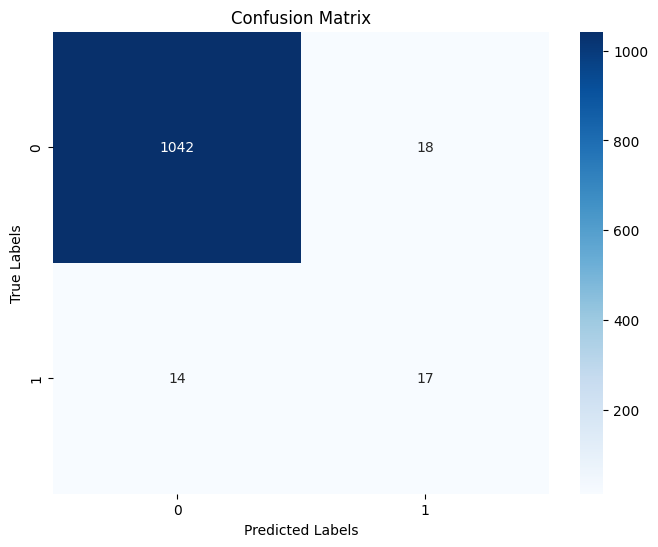


Model Summary:
Random Forest Model Summary:
Number of Trees: 100
Max Depth: 10
Min Samples per Leaf: 5
Max Features: sqrt
Bootstrap Features: True


In [27]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Load the test dataset
test_data_path = "/test.csv"  # Change this to your actual test dataset path
df_test = pd.read_csv(test_data_path)

# Split target and features
y_test = df_test.iloc[:, 0]  # Assuming the first column is the target
X_test = df_test.iloc[:, 1:]  # Rest are features
# Scale features
X_test = scaler.transform(X_test)
# Load the trained model
with open("/random_forest_model.pt", "rb") as model_file:
    xgb_model = pickle.load(model_file)

# Get predictions
y_proba = xgb_model.predict_proba(X_test)

y_proba_class1 = np.array([d[1] for d in y_proba])
# Set threshold

threshold = 0.72  # Can be adjusted based on precision-recall analysis
y_pred_with_threshold = (y_proba_class1 >= threshold).astype(int)


pred_labels=y_pred_with_threshold
# Calculate metrics
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
report = classification_report(y_test, pred_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print("\nModel Summary:")
xgb_model.summary()
